# Data-Centric NLP 대회: 주제 분류 프로젝트

## Load Libraries

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

## Set Hyperparameters

In [2]:
SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [4]:
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, '../data')
OUTPUT_DIR = os.path.join(BASE_DIR, '../output')

## Load Tokenizer and Model

In [5]:
model_name = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Dataset

In [24]:
data = pd.read_csv(os.path.join(DATA_DIR, 'ascii20_jduck.csv'))
dataset_train, dataset_valid = train_test_split(data, test_size=0.2, random_state=SEED)

In [25]:
class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        targets = data['target']
        self.inputs = []; self.labels = []
        for text, label in zip(input_texts, targets):
            tokenized_input = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }

    def __len__(self):
        return len(self.labels)

In [26]:
data_train = BERTDataset(dataset_train, tokenizer)
data_valid = BERTDataset(dataset_valid, tokenizer)

In [27]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Define Metric

In [28]:
f1 = evaluate.load('f1')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels, average='macro')


## Train Model

In [29]:
### for wandb setting
os.environ['WANDB_DISABLED'] = 'true'

In [30]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    do_predict=True,
    logging_strategy='steps',
    eval_strategy='steps',
    save_strategy='steps',
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    save_total_limit=2,
    learning_rate= 2e-05,
    adam_beta1 = 0.9,
    adam_beta2 = 0.999,
    adam_epsilon=1e-08,
    weight_decay=0.01,
    lr_scheduler_type='linear',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    greater_is_better=True,
    seed=SEED
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data_train,
    eval_dataset=data_valid,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [32]:
trainer.train()

Step,Training Loss,Validation Loss,F1
100,0.916600,0.329589,0.909358
200,0.294500,0.227893,0.932429
300,0.225700,0.178058,0.950716
400,0.199300,0.137496,0.961489
500,0.145600,0.112245,0.969001
600,0.130600,0.108152,0.970493
700,0.105600,0.106806,0.973131
800,0.112900,0.085504,0.977207
900,0.058300,0.093449,0.978162
1000,0.048900,0.093452,0.976351


TrainOutput(global_step=1618, training_loss=0.15678543150793342, metrics={'train_runtime': 2394.7548, 'train_samples_per_second': 21.614, 'train_steps_per_second': 0.676, 'total_flos': 1.3619239606272e+16, 'train_loss': 0.15678543150793342, 'epoch': 2.0})

## Evaluate Model

In [33]:
dataset_test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

In [34]:
model.eval()
preds = []

for idx, sample in tqdm(dataset_test.iterrows(), total=len(dataset_test), desc="Evaluating"):
    inputs = tokenizer(sample['text'], return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(torch.nn.Softmax(dim=1)(logits), dim=1).cpu().numpy()
        preds.extend(pred)

Evaluating: 100%|██████████| 30000/30000 [05:39<00:00, 88.25it/s]


In [35]:
dataset_test['target'] = preds
dataset_test.to_csv(os.path.join(BASE_DIR, 'output.csv'), index=False) 

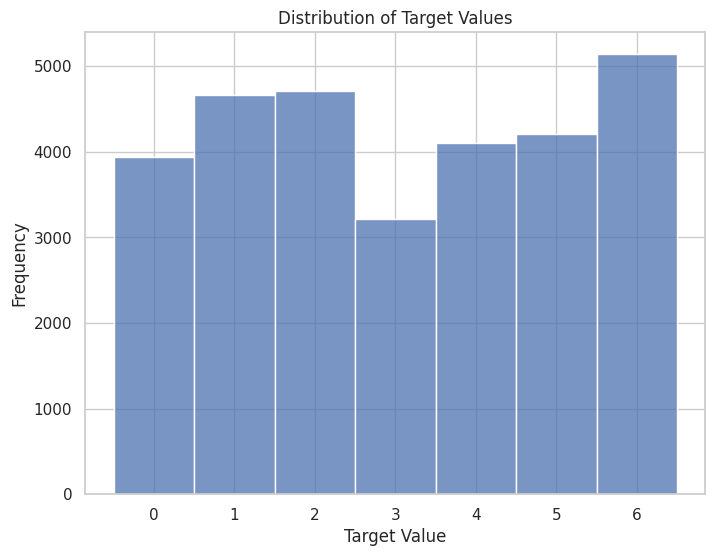

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn 스타일 설정
sns.set(style="whitegrid")

# 히스토그램 그리기
plt.figure(figsize=(8, 6))
sns.histplot(dataset_test['target'], bins=7, kde=False, discrete=True)  # kde=False는 밀도 곡선을 생략

# 그래프 제목과 레이블 추가
plt.title('Distribution of Target Values')
plt.xlabel('Target Value')
plt.ylabel('Frequency')

plt.show()
